In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import missingno as msno
import shap
import eli5

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from yellowbrick.cluster import KElbowVisualizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss
from eli5.sklearn import PermutationImportance


b:\Data Science Work\practical-ML\dataenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Train Data

In [2]:
train_df = pd.read_csv("data/train.csv", index_col="PassengerId")
train_shape = train_df.shape
display(train_df.head())
print(f"Entries: {train_shape[0]}\nFeatures: {train_shape[1]}")

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Entries: 891
Features: 11


## Data Preprocessing

In [3]:
# initial dtypes of each column
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


We observe that cabin is mostly made up of nulls. We also see from the preview of the data that while it is classed as object, it is actually string type, which cannot be categorized and does not contribute much to the outcome. Thus, this column should not be used for analyses.

We also notice that Age has a significant number of nulls.

In [4]:
train_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


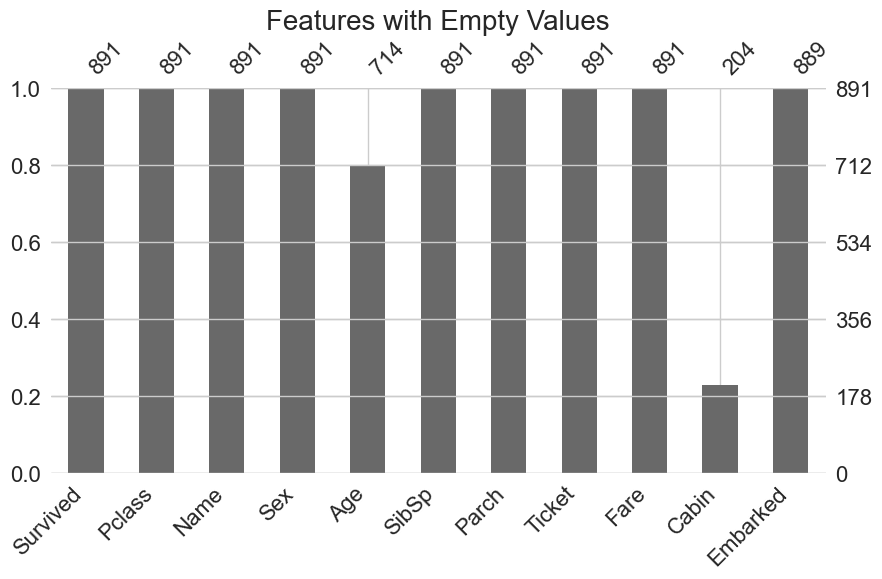

In [5]:
#  null entries
fig, ax = plt.subplots(figsize=(10,5))
msno.bar(train_df, ax=ax)
ax.set_title("Features with Empty Values",
             fontdict={"fontsize": 20})
plt.savefig("viz/null_before.png", bbox_inches="tight")

<Axes: >

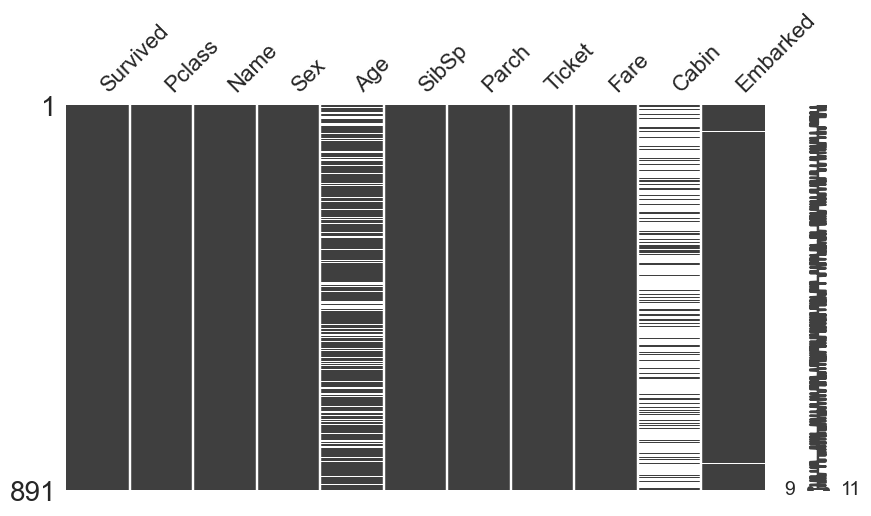

In [6]:
msno.matrix(train_df, figsize=(10,5))

In [7]:
# no. of unique values in each column
train_df.nunique()

Survived      2
Pclass        3
Name        891
Sex           2
Age          88
SibSp         7
Parch         7
Ticket      681
Fare        248
Cabin       147
Embarked      3
dtype: int64

In [8]:
#  check if there are duplicated passengers
count_duplicated_passengers = train_df.Name.duplicated().sum()
print(f"There are {count_duplicated_passengers} duplicated passengers in this log.")

There are 0 duplicated passengers in this log.


What needs to be done:
1. reformat column names -> lowercase 
2. deal with entries/features with null values: impute or drop

In [9]:
#  reformat column names
def lowercase_columns(df):
    df.columns = df.columns.str.lower()
    return df

train_df = lowercase_columns(train_df)
train_df.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Embarked was imputed using the mode as there were only 3 missing values and it is most likely that it would follow the values of the most frequent S.

In [10]:
#  check entries with null Embarked values
null_embarked = train_df.embarked.isna()
display(train_df[null_embarked].head())
print(f"There are {null_embarked.sum()} passengers with no embarked specified.")
print(f"That is {(null_embarked.sum() / train_df.shape[0]) * 100:.2f}% of the entire train_df with no specified embarked")

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


There are 2 passengers with no embarked specified.
That is 0.22% of the entire train_df with no specified embarked


In [11]:
#  impute null embarked values with mode values
def embarked_solution(df):
    df['embarked'] = df['embarked'].fillna(df['embarked'].mode()[0])
    return df

train_df = embarked_solution(train_df)
train_df

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


Now looking at Age

In [12]:
#  check entries with null Age values
null_age = train_df.age.isna()
display(train_df[null_age].head())
print(f"There are {null_age.sum()} passengers with no age specified.")
print(f"That is {(null_age.sum() / train_df.shape[0]) * 100:.2f}% of the entire train_df with no specified age")

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
PassengerId,,,,,,,,,,,
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q


There are 177 passengers with no age specified.
That is 19.87% of the entire train_df with no specified age


<Axes: title={'center': 'Age'}, ylabel='Frequency'>

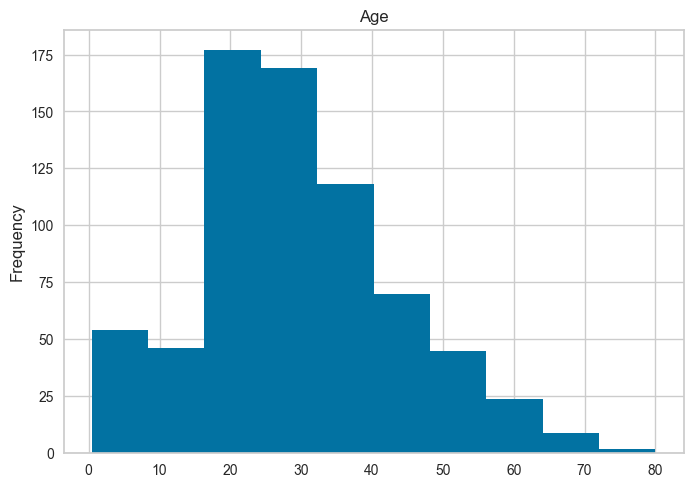

In [13]:
#  looking at distribution of age 
train_df.age.plot.hist(title="Age")

In [14]:
#  impute with reference to title (Mr., Ms., Mrs.), passenger class, and sex
def age_solution(df):
    
    #  checking possible titles
    df['title'] = df['name'].apply(lambda name: name.split(',')[1].split('.')[0].strip())

    # making Miss into Ms
    df['title'] = df['title'].replace('Miss','Ms')

    grouped_age_df = df[["pclass", "sex", "title", "age"]].copy()
    df["age"] = grouped_age_df.groupby(['pclass','sex','title'])["age"].transform(lambda x: x.fillna(x.median()))
    return df

train_df = age_solution(train_df)
train_df

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,title
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Ms
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Rev
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Ms
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,18.0,1,2,W./C. 6607,23.4500,NaN,S,Ms


Imputation for age was done by using the median (due to the skewed nature of the plot) and with reference to title and passenger class.

The title and passenger class were used as reference as these can be used as a general guide for the age of a person. For instance, especially considering the time period, it is more likely for someone with a title "Mrs" to be older than someone with a title "Ms". Passenger class was also used as those who are older are more likely to make more money. However, young companions or family members may also be the same passenger class. As such, the titles provide more information on the passenger and their age. Sex was also used for further classification.

Looking at Cabin Column

In [15]:
#  check entries with null Cabin values
null_cabin = train_df.cabin.isna()
display(train_df[null_cabin].head())
print(f"There are {null_cabin.sum()} passengers with no cabin specified.")
print(f"That is {(null_cabin.sum() / train_df.shape[0]) * 100:.2f}% of the entire train_df with no specified cabin ID")

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,title
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Ms
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr
6,0,3,"Moran, Mr. James",male,26.0,0,0,330877,8.4583,NaN,Q,Mr
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,Master


There are 687 passengers with no cabin specified.
That is 77.10% of the entire train_df with no specified cabin ID


In [16]:
#  drop cabin column
def cabin_solution(df):
    return df.drop(columns=["cabin"])

train_df = cabin_solution(train_df)
train_df

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked,title
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Ms
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mr
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S,Rev
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S,Ms
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,18.0,1,2,W./C. 6607,23.4500,S,Ms


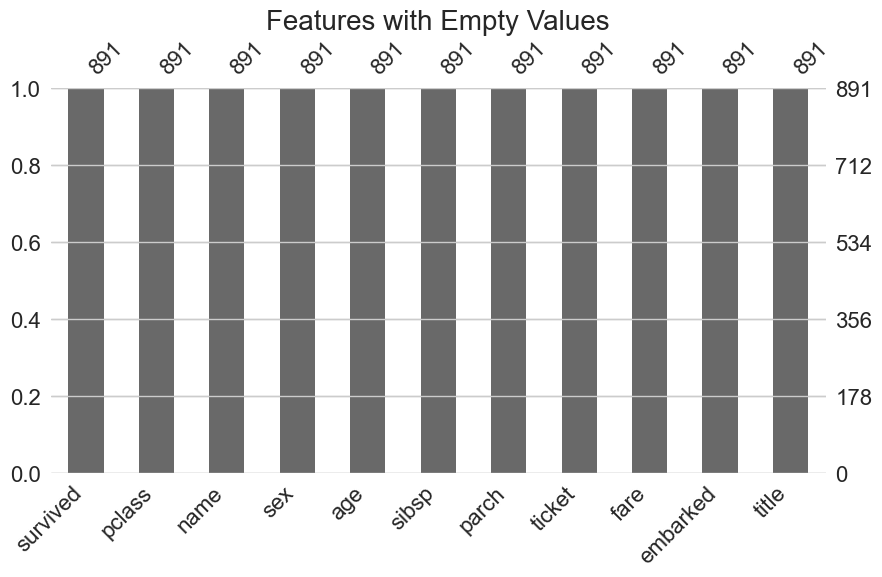

In [17]:
#  check if there are no more empty values
#  null entries
fig, ax = plt.subplots(figsize=(10,5))
msno.bar(train_df, ax=ax)
ax.set_title("Features with Empty Values",
             fontdict={"fontsize": 20})
plt.savefig("viz/null_after.png", bbox_inches="tight")

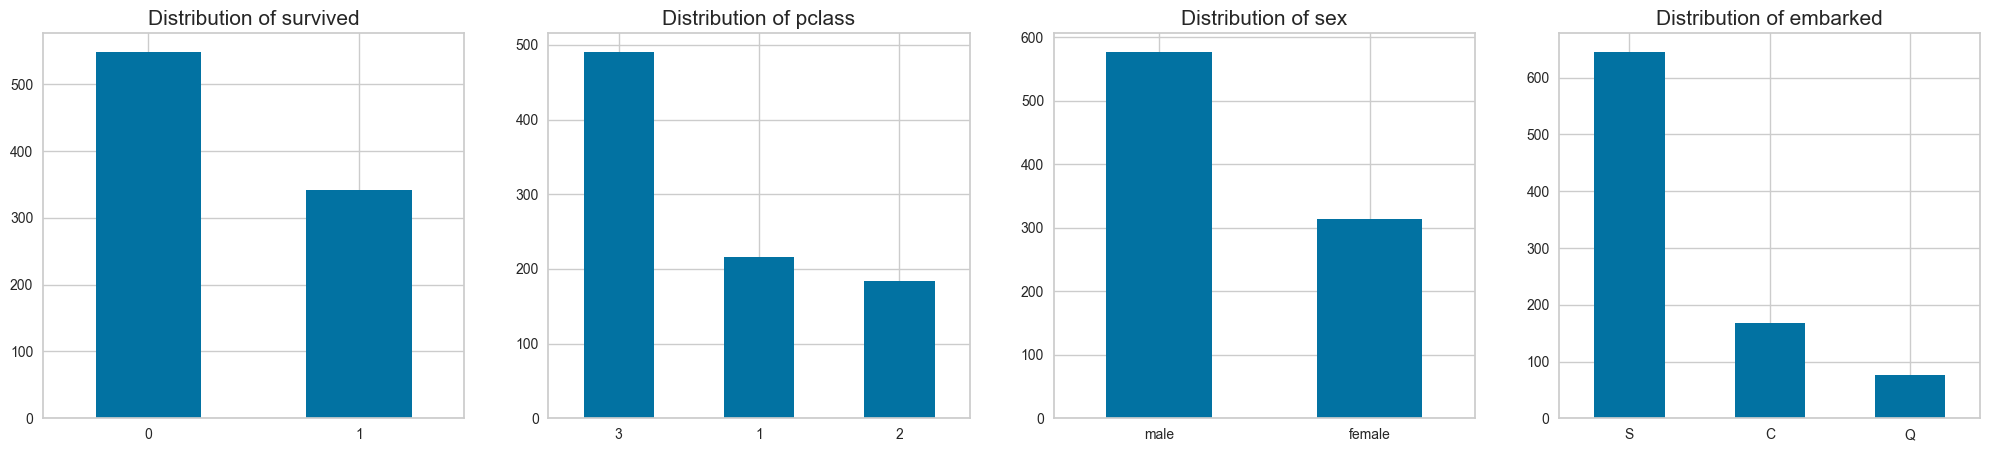

In [18]:
fig, axs = plt.subplots(1,4, figsize=(25,5))

bar_list = ["survived", 
            "pclass",
            "sex",
            "embarked",]

for i, col in enumerate(bar_list):
    train_df[col].value_counts().plot(kind="bar",
                       ax=axs[i],
                       rot=0)
    axs[i].set_title(f"Distribution of {col}",
                     fontdict={"fontsize": 15})
    
plt.savefig("viz/categ_distribution.png",
            bbox_inches="tight")

The following were observed:
- Survived: **61.62%** of the passengers perished, indicating that majority of the passengers  did not make it out alive
- Passenger Class: most of the passengers belonged to the 3rd class,  valuing at **55.1%** of the overall
- Sex: there were more male **(64.75&)** as compared to female passengers
- Embarked: most passengers embarked the Titanic from Southampton, equivalent to **72.50%**

Survival rate of 1: 62.96%
Survival rate of 2: 47.28%
Survival rate of 3: 24.24%
Survival rate of female: 74.20%
Survival rate of male: 18.89%
Survival rate of C: 55.36%
Survival rate of Q: 38.96%
Survival rate of S: 33.90%


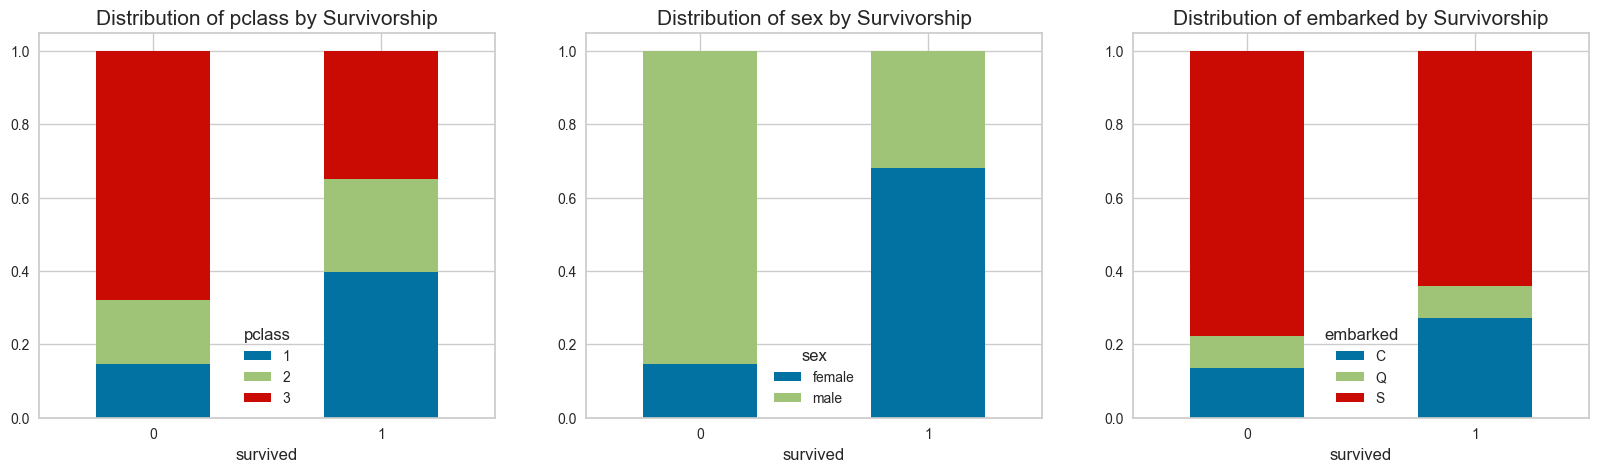

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(20,5))

col_list = ["pclass",
            "sex",
            "embarked",]

for i, col in enumerate(col_list):
    pd.crosstab(train_df["survived"], train_df[col], normalize="index").plot.bar(stacked=True, ax=axs[i], rot=0)
    axs[i].set_title(f"Distribution of {col} by Survivorship",
                     fontdict={"fontsize": 15})

plt.savefig("viz/categ_dist_survivor.png",
            bbox_inches="tight")
    
for col in col_list:
    survival_rates = pd.crosstab(train_df["survived"], train_df[col], normalize="columns").loc[1]
    for category in survival_rates.index:
        print(f"Survival rate of {category}: {survival_rates[category] * 100:.2f}%")
    

From the visualization above, we can observe that:
- Higher class passengers had a higher chance of surviving
- Female passengers had a higher chance of surviving
- Passengers from Cherbourg had a higher chance of surviving

Historically, since there were only limited lifeboats available on ship, female passengers were given more priority together with their children as compared to males. Moreover, the said lifeboats were in closer proximity to the uper-class cabins, higher class passengers were able to have a higher chance of surviving.

Mean Age: 29.14
Median Age: 26.0

Mean Fare: 32.20
Median Fare: 14.45


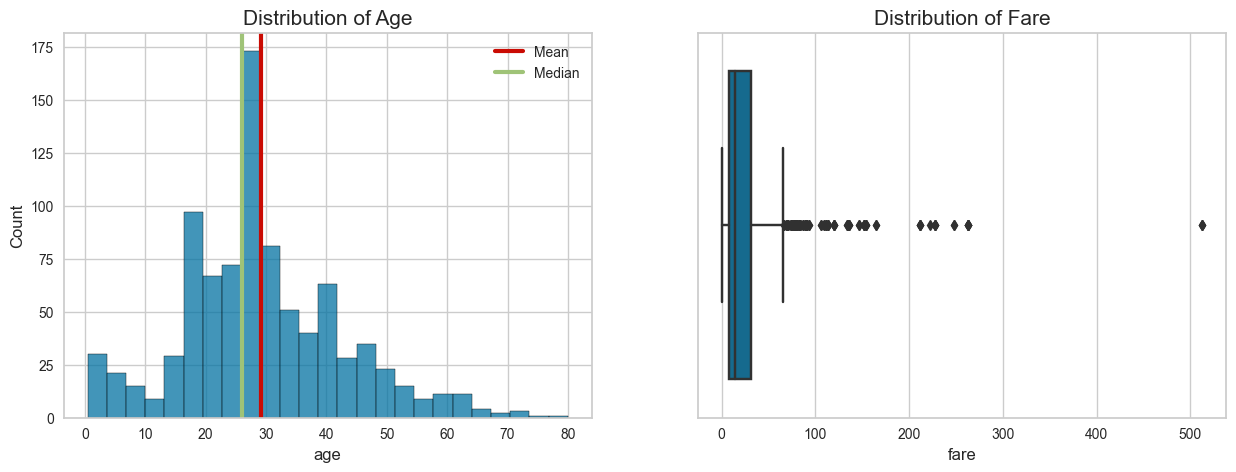

In [20]:
fig, axs = plt.subplots(1,2, figsize=(15,5))

sns.histplot(data=train_df,
             x="age",
             ax=axs[0])
axs[0].set_title("Distribution of Age",
                 fontdict={"fontsize": 15})
axs[0].axvline(x=train_df.age.mean(),
               linewidth=3, 
               color='r',
               label="Mean"
               )
axs[0].axvline(x=train_df.age.median(),
               linewidth=3, 
               color='g',
               label="Median"
               )
axs[0].legend()

sns.boxplot(data=train_df,
            x="fare",
            ax=axs[1])
axs[1].set_title("Distribution of Fare",
                 fontdict={"fontsize": 15})

plt.savefig("viz/num_distribution.png",
            bbox_inches="tight")

print(f"Mean Age: {train_df.age.mean():.2f}")
print(f"Median Age: {train_df.age.median()}\n")
print(f"Mean Fare: {train_df.fare.mean():.2f}")
print(f"Median Fare: {train_df.fare.median():.2f}")

A key obseervation from age depicts that most of the passengers are **middle-aged** with a count of 891 passengers. Average age of the passengers is 29.14 while its middle value is 26. On the other hand, we can deduce that the fare of the passengers is in the average of **32.20** and a median fare of **14.45**

mean               min          max      
sex          female       male female  male female  male
survived                                                
0         24.049383  30.789530   2.00  1.00   57.0  74.0
1         28.416309  27.418991   0.75  0.42   63.0  80.0

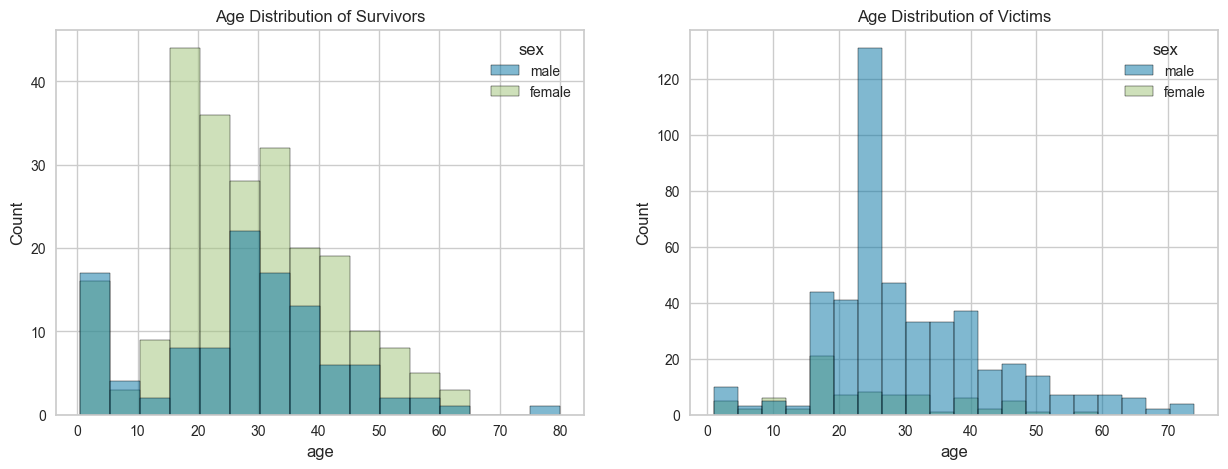

In [21]:
survivors = train_df.query("survived == 1")
victims = train_df.query("survived == 0")

fig, axs = plt.subplots(1,2, figsize=(15,5))

sns.histplot(data=survivors,
             x="age",
             hue="sex",
             ax=axs[0],
             hue_order=["male", "female"]
             )
axs[0].set_title("Age Distribution of Survivors")

sns.histplot(data=victims,
             x="age",
             hue="sex",
             ax=axs[1],
             hue_order=["male", "female"]
             )
axs[1].set_title("Age Distribution of Victims")

plt.savefig("viz/age_dist_survivor.png",
            bbox_inches="tight")

sex_numerical = pd.crosstab(train_df.survived, train_df.sex, train_df.age, aggfunc=[np.mean, min, max])
display(sex_numerical)

In [22]:
def categorical_encoding(df):
    #  label encoding
    df['sex'] = df['sex'].replace(['female','male'],[0,1])
    
    #  one-hot encoding
    df = pd.get_dummies(data=df, columns=["embarked"])
    return df

train_df = categorical_encoding(train_df)
train_df.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,title,embarked_C,embarked_Q,embarked_S
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,Mr,0,0,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,Mrs,1,0,0
3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,Ms,0,0,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,Mrs,0,0,1
5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,Mr,0,0,1


In [23]:
#  companion count column
def companion_solution(df):
    df["companions"] = df.sibsp + df.parch
    df = df.drop(columns=["sibsp", "parch"])
    return df

train_df = companion_solution(train_df)
train_df.head()

,survived,pclass,name,sex,age,ticket,fare,title,embarked_C,embarked_Q,embarked_S,companions
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",1,22.0,A/5 21171,7.2500,Mr,0,0,1,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,PC 17599,71.2833,Mrs,1,0,0,1
3,1,3,"Heikkinen, Miss. Laina",0,26.0,STON/O2. 3101282,7.9250,Ms,0,0,1,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,113803,53.1000,Mrs,0,0,1,1
5,0,3,"Allen, Mr. William Henry",1,35.0,373450,8.0500,Mr,0,0,1,0


Survival rate for passengers with 0 companions: 30.35%
Survival rate for passengers with 1 companions: 55.28%
Survival rate for passengers with 2 companions: 57.84%
Survival rate for passengers with 3 companions: 72.41%
Survival rate for passengers with 4 companions: 20.00%
Survival rate for passengers with 5 companions: 13.64%
Survival rate for passengers with 6 companions: 33.33%
Survival rate for passengers with 7 companions: 0.00%
Survival rate for passengers with 10 companions: 0.00%


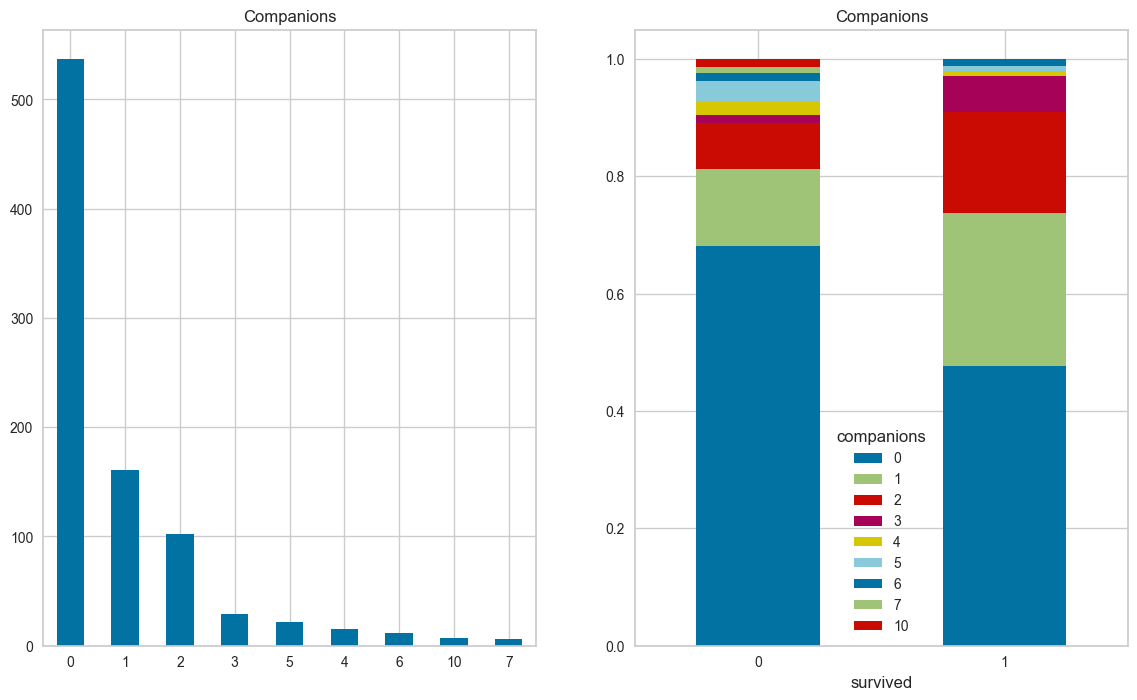

In [24]:
fig, axs = plt.subplots(1,2, figsize=(14,8))

train_df.companions.value_counts().plot.bar(ax=axs[0], rot=0,title="Companions")
pd.crosstab(train_df.survived, train_df.companions, normalize="index").plot.bar(stacked=True, ax=axs[1],rot=0,title="Companions")

survivor_companions = pd.crosstab(train_df.survived, train_df.companions, normalize="columns").loc[1] * 100

for idx in survivor_companions.index:
    print(f"Survival rate for passengers with {idx} companions: {survivor_companions[idx]:.2f}%")

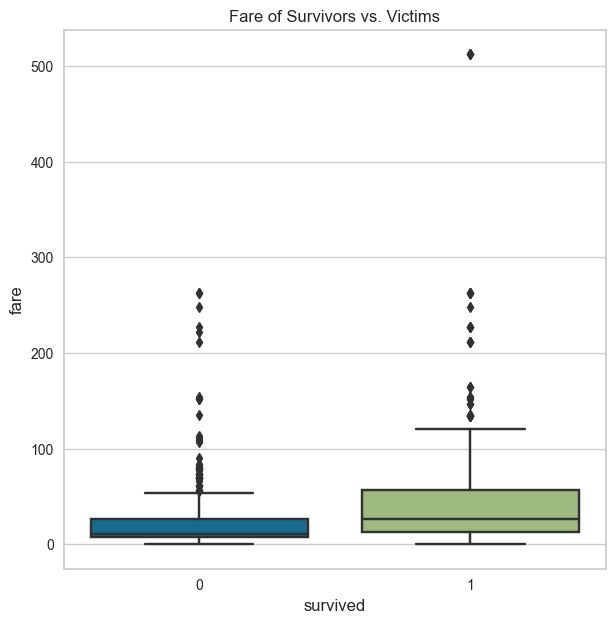

Survivors Mean Fare: 48.40
Survivors Median Fare: 26.00
Victims Mean Fare: 22.12
Victims Median Fare: 10.50


In [25]:
fig, axs = plt.subplots(1,1, figsize=(7,7))

sns.boxplot(data=train_df,
            x="survived", y="fare")
axs.set_title("Fare of Survivors vs. Victims")
plt.show()

print(f"Survivors Mean Fare: {train_df.query('survived==1')['fare'].mean():.2f}")
print(f"Survivors Median Fare: {train_df.query('survived==1')['fare'].median():.2f}")
print(f"Victims Mean Fare: {train_df.query('survived==0')['fare'].mean():.2f}")
print(f"Victims Median Fare: {train_df.query('survived==0')['fare'].median():.2f}")

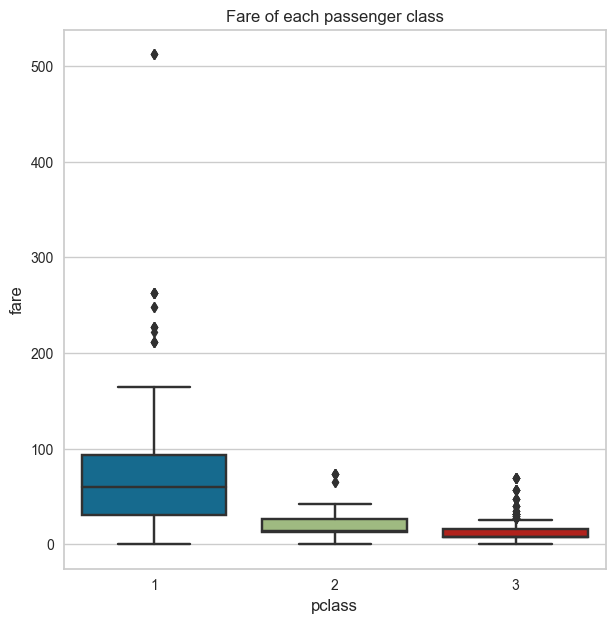

pclass 1 Mean & Median Fare: 84.15 | 60.29
pclass 2 Mean & Median Fare: 20.66 | 14.25
pclass 3 Mean & Median Fare: 13.68 | 8.05


In [26]:
fig, axs = plt.subplots(1,1, figsize=(7,7))

sns.boxplot(data=train_df,
            x="pclass", y="fare")
axs.set_title("Fare of each passenger class")
plt.show()

print(f"pclass 1 Mean & Median Fare: {train_df.query('pclass==1')['fare'].mean():.2f} | {train_df.query('pclass==1')['fare'].median():.2f}")
print(f"pclass 2 Mean & Median Fare: {train_df.query('pclass==2')['fare'].mean():.2f} | {train_df.query('pclass==2')['fare'].median():.2f}")
print(f"pclass 3 Mean & Median Fare: {train_df.query('pclass==3')['fare'].mean():.2f} | {train_df.query('pclass==3')['fare'].median():.2f}")

### Loading Test Data

In [27]:
test_df = pd.read_csv("data/test.csv", index_col="PassengerId")

display(test_df.head())
print(test_df.shape)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


(418, 10)


In [28]:
def preprocessing(df):
    df = lowercase_columns(df)
    df = embarked_solution(df)
    df = age_solution(df)
    df = cabin_solution(df)
    df = categorical_encoding(df)
    df = companion_solution(df)
    df = df.dropna(subset=["fare"])
    return df

test_df = preprocessing(test_df)

display(test_df.head())
print(test_df.shape)

,pclass,name,sex,age,ticket,fare,title,embarked_C,embarked_Q,embarked_S,companions
PassengerId,,,,,,,,,,,
892,3,"Kelly, Mr. James",1,34.5,330911,7.8292,Mr,0,1,0,0
893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,363272,7.0000,Mrs,0,0,1,1
894,2,"Myles, Mr. Thomas Francis",1,62.0,240276,9.6875,Mr,0,1,0,0
895,3,"Wirz, Mr. Albert",1,27.0,315154,8.6625,Mr,0,0,1,0
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,3101298,12.2875,Mrs,0,0,1,2


(417, 11)


### K-Means: Clustering passengers

In [29]:
train_kmeans_df = train_df.copy()
kmeans_df = train_kmeans_df.loc[:, train_kmeans_df.dtypes != "object"].copy()
kmeans_df = kmeans_df[kmeans_df.columns[1:]]
display(kmeans_df.head())
print(kmeans_df.shape)

,pclass,sex,age,fare,embarked_C,embarked_Q,embarked_S,companions
PassengerId,,,,,,,,
1,3,1,22.0,7.2500,0,0,1,1
2,1,0,38.0,71.2833,1,0,0,1
3,3,0,26.0,7.9250,0,0,1,0
4,1,0,35.0,53.1000,0,0,1,1
5,3,1,35.0,8.0500,0,0,1,0


(891, 8)


In [30]:
#  minmax scaling dataframe
minmax = MinMaxScaler()
scaled_kmeans = minmax.fit_transform(kmeans_df)
kmeans_df = pd.DataFrame(scaled_kmeans, columns=kmeans_df.columns)
kmeans_df.describe()

,pclass,sex,age,fare,embarked_C,embarked_Q,embarked_S,companions
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.654321,0.647587,0.360943,0.062858,0.188552,0.086420,0.725028,0.090460
std,0.418036,0.477990,0.169591,0.096995,0.391372,0.281141,0.446751,0.161346
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.000000,0.258608,0.015440,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.321438,0.028213,0.000000,0.000000,1.000000,0.000000
75%,1.000000,1.000000,0.456522,0.060508,0.000000,0.000000,1.000000,0.100000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Using ALL features

In [31]:
# #  initialize k array
# k_list = [k for k in range(2,16)]


# #  initialize silhouette coefficient array
# silhouette_list = []

# #  initialize davies-bouldin score array
# db_list = []

# data = kmeans_df.copy()     #  excludes port of embarkment 
# for k in k_list:
#     #  running kmeans algorithm
#     kmeans = KMeans(n_clusters=k, random_state=10).fit(data)
#     clusters = kmeans.labels_
    
#     #  for silhouette coeffiicent
#     silhouette_coef = silhouette_score(data, clusters)
#     silhouette_list.append(silhouette_coef)
    
#     #  for davies-bouldin score
#     db_score = davies_bouldin_score(data, clusters)
#     db_list.append(db_score)
    
# visualizer = KElbowVisualizer(kmeans, k=(2,16), timings=False)

# visualizer.fit(data)       
# visualizer.show()       
# plt.show()

In [32]:
# fig, ax = plt.subplots(figsize=(8,5))
# plot1 = ax.plot(k_list, db_list, "*-", color="green", label="Davies-Bouldin")

# ax2 = ax.twinx()
# plot2 = ax2.plot(k_list, silhouette_list, "x-", color="red", label="Silhouette")

# plots = plot1+plot2
# labels = [plot.get_label() for plot in plots]

# ax.legend(plots, labels)

In [33]:
# #  fitting the KMeans model to the data
# k = 10
# kmeans = KMeans(n_clusters=k, random_state=10).fit(data)
# clusters = kmeans.labels_

# #  add clusters to train_kmeans_df
# train_kmeans_df["cluster"] = clusters

# train_kmeans_df.cluster.value_counts().plot.bar(rot=0, title="Clusters", figsize=(7,5))

In [34]:
# #  visualize main characteristics
# fig, axs = plt.subplots(1, 3, figsize=(20,5))

# col_list = ["pclass",
#             "sex",
#             "companions"]

# for i, col in enumerate(col_list):
#     pd.crosstab(train_kmeans_df["cluster"], train_kmeans_df[col]).plot.bar(stacked=True, ax=axs[i], rot=0)
#     axs[i].set_title(col)

In [35]:
# fig, axs = plt.subplots(1, 2, figsize=(20,5))

# sns.boxplot(data=train_kmeans_df,
#             x="cluster",
#             y="age",
#             ax=axs[0])
# axs[0].set_title("Age by Cluster")

# sns.boxplot(data=train_kmeans_df,
#             x="cluster",
#             y="fare",
#             ax=axs[1])
# axs[1].set_title("Fare by Cluster")

# display(train_kmeans_df.groupby("cluster")["age"].agg(["median", "min", "max"]))
# display(train_kmeans_df.groupby("cluster")["fare"].agg(["median", "min", "max"]))

#### Without Embarked feature

In [37]:
#  relevant features
relevant_features = ["pclass",
                     "sex",
                     "age",
                     "fare",
                     "companions"]

#  initialize k array
k_list = [k for k in range(2,16)]


#  initialize silhouette coefficient array
silhouette_list = []

#  initialize davies-bouldin score array
db_list = []

data = kmeans_df[relevant_features].copy()     #  excludes port of embarkment 
for k in k_list:
    #  running kmeans algorithm
    kmeans = KMeans(n_clusters=k, random_state=10).fit(data)
    clusters = kmeans.labels_
    
    #  for silhouette coeffiicent
    silhouette_coef = silhouette_score(data, clusters)
    silhouette_list.append(silhouette_coef)
    
    #  for davies-bouldin score
    db_score = davies_bouldin_score(data, clusters)
    db_list.append(db_score)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` exp

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` exp

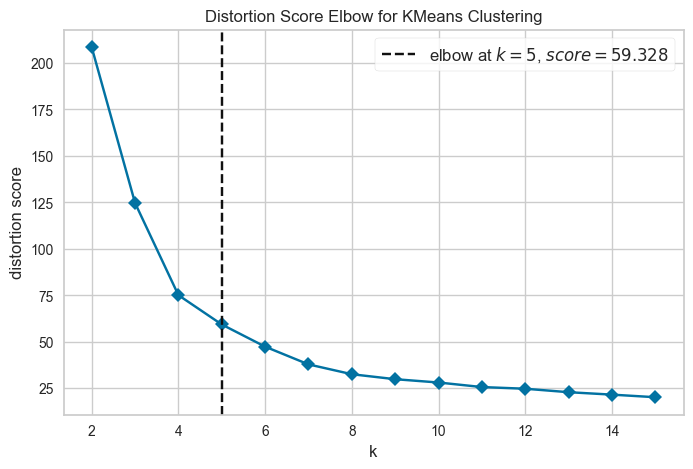

In [42]:
fig, ax = plt.subplots(figsize=(8,5))
visualizer = KElbowVisualizer(kmeans, k=(2,16), timings=False, ax=ax)

visualizer.fit(data)       
visualizer.show()   
plt.show()

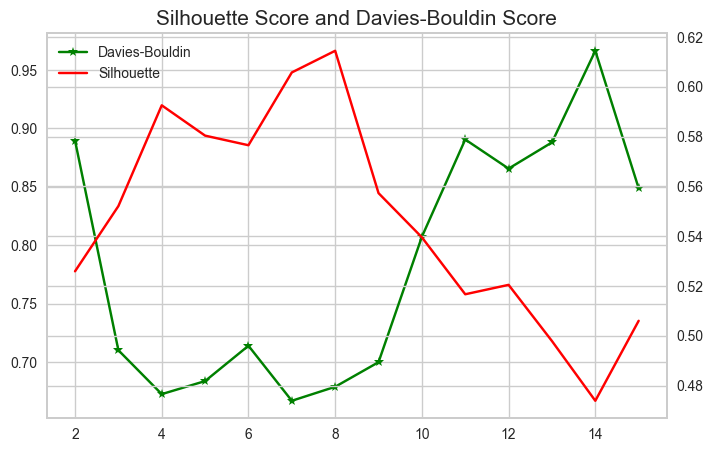

In [41]:
fig, ax = plt.subplots(figsize=(8,5))
plot1 = ax.plot(k_list, db_list, "*-", color="green", label="Davies-Bouldin")

ax2 = ax.twinx()
plot2 = ax2.plot(k_list, silhouette_list, "x-", color="red", label="Silhouette")

plots = plot1+plot2
labels = [plot.get_label() for plot in plots]

ax.set_title("Silhouette Score and Davies-Bouldin Score",
              fontdict={"fontsize": 15})
plt.savefig("viz/db_s.png",
            bbox_inches="tight")
ax.legend(plots, labels)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


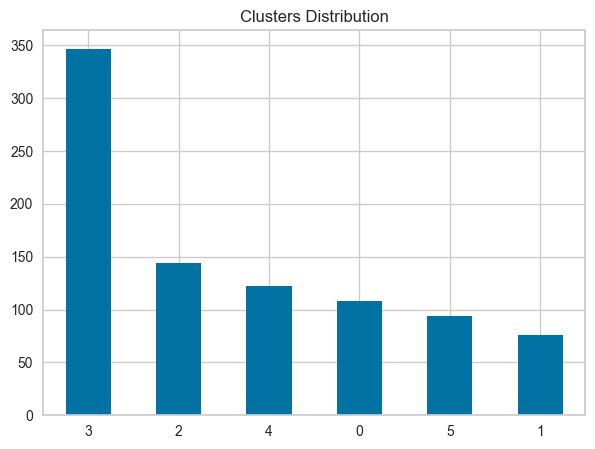

In [44]:
#  fitting the KMeans model to the data
k = 6
kmeans = KMeans(n_clusters=k, random_state=10).fit(data)
clusters = kmeans.labels_

#  add clusters to train_kmeans_df
train_kmeans_df["cluster"] = clusters

train_kmeans_df.cluster.value_counts().plot.bar(rot=0, title="Clusters Distribution", figsize=(7,5))
plt.savefig("viz/cluster_dist.png",
            bbox_inches="tight"
            )

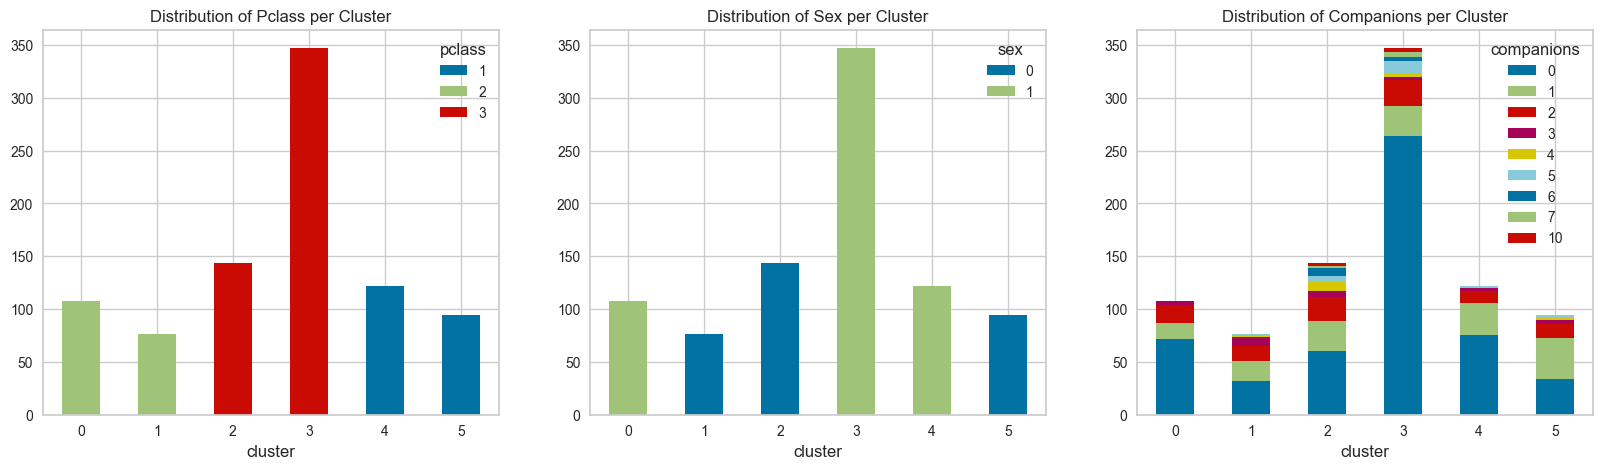

In [46]:
#  visualize main characteristics
fig, axs = plt.subplots(1, 3, figsize=(20,5))

col_list = ["pclass",
            "sex",
            "companions"]

for i, col in enumerate(col_list):
    pd.crosstab(train_kmeans_df["cluster"], train_kmeans_df[col]).plot.bar(stacked=True, ax=axs[i], rot=0)
    axs[i].set_title(f"Distribution of {col.capitalize()} per Cluster")
    
    plt.savefig("viz/categ_dist_cluster.png",
            bbox_inches="tight"
            )

,median,min,max
cluster,,,
0,31.0,0.67,70.0
1,28.0,2.00,57.0
2,18.0,0.75,63.0
3,26.0,0.42,74.0
4,40.0,0.92,80.0
5,35.0,2.00,63.0


,median,min,max
cluster,,,
0,13.00000,0.0000,73.5000
1,22.00000,10.5000,65.0000
2,12.47500,6.7500,69.5500
3,7.92500,0.0000,69.5500
4,41.26250,0.0000,512.3292
5,82.66455,25.9292,512.3292


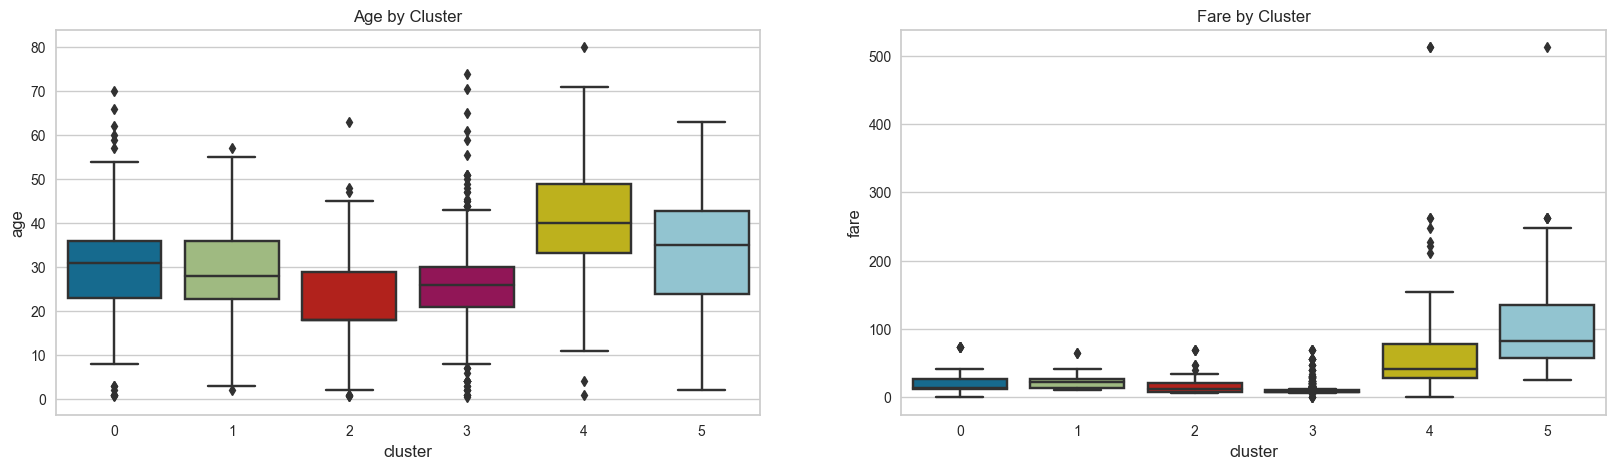

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(20,5))

sns.boxplot(data=train_kmeans_df,
            x="cluster",
            y="age",
            ax=axs[0])
axs[0].set_title("Age by Cluster")

sns.boxplot(data=train_kmeans_df,
            x="cluster",
            y="fare",
            ax=axs[1])
axs[1].set_title("Fare by Cluster")

display(train_kmeans_df.groupby("cluster")["age"].agg(["median", "min", "max"]))
display(train_kmeans_df.groupby("cluster")["fare"].agg(["median", "min", "max"]))

plt.savefig("viz/numerical_dist_cluster.png",
            bbox_inches="tight"
            )

<h3> Correlation Heatmap</h3>

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


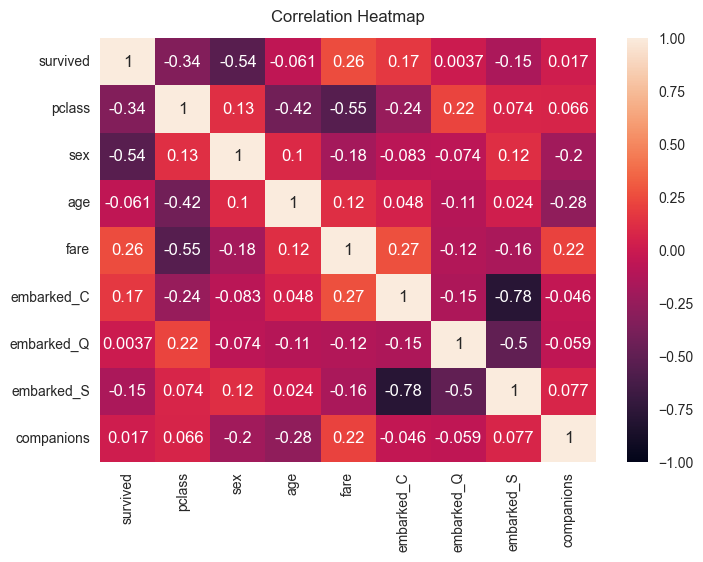

In [48]:
heatmap=sns.heatmap(train_df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title("Correlation Heatmap", fontdict={'fontsize':12},pad=12)

plt.savefig("viz/corr_heatmap.png",
            bbox_inches="tight"
            )

By getting the absolute value of the correlation, we can see the strengths of each correlation coefficient <br>
According to **Juhari (2013)**, this is the basis for the strength value of a correlation coefficient: 
|**Absolute Value**|**Strength of correlation**|
|:----------------:|:-------------------------:|
|0.91-1.00|Very Strong|
|0.71-0.90|Strong|
|0.51-0.70|Moderate|
|0.31-0.50|Weak|
|0.01-0.30|Very Weak|
|0.00|No correlation|

Based on this table, we can determine the strength of the correlation coefficient such that, <br>
|**Correlation coefficient**|**Strength**|
|:-------------------------:|:----------:|
|n/a|Very Strong|
|embarked_S vs embarked_C|Strong|
|sex vs survived <br> fare vs pclass <br> embarked_S vs embarked_Q|Moderate|
|pclass vs survived <br> age vs pclass|Weak|
|age vs survived <br> fare vs survived <br> embarked_C vs survived <br> embarked_Q vs survived<br> embarked_S vs survived <br> companions vs survived <br>sex vs pclass <br>embarked_C vs pclass <br>embarked_Q vs pclass <br>embarked_S vs pclass <br>companions vs pclass <br>age vs sex <br>fare vs sex <br>  embarked_C vs sex <br> embarked_Q vs sex <br> emabrked_S vs sex <br> companions vs sex <br> fare vs age <br> ...|Very Weak|


<h3>Logistic Regression</h3>

In [95]:
train_df.head()

,survived,pclass,name,sex,age,ticket,fare,title,embarked_C,embarked_Q,embarked_S,companions
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",1,22.0,A/5 21171,7.2500,Mr,0,0,1,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,PC 17599,71.2833,Mrs,1,0,0,1
3,1,3,"Heikkinen, Miss. Laina",0,26.0,STON/O2. 3101282,7.9250,Ms,0,0,1,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,113803,53.1000,Mrs,0,0,1,1
5,0,3,"Allen, Mr. William Henry",1,35.0,373450,8.0500,Mr,0,0,1,0


Logistic regression estimates the probability of an event occurring, such as voted or didn't vote, based on a given dataset of independent variables. For this case, survived and not survived. Note that the response variable would be the variable survived such that 0:= not survived and 1:= survived.

In [96]:
X=train_df.drop(['survived','name','ticket','title'], axis=1)
y=train_df['survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)

In [97]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
y_pred

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


array([0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1], dtype=int64)

In [98]:
# Accuracy of the model
accuracy_score(y_pred, y_test)

0.7966101694915254

In [99]:
predictions = log_reg.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       184
           1       0.74      0.70      0.72       111

    accuracy                           0.80       295
   macro avg       0.78      0.78      0.78       295
weighted avg       0.79      0.80      0.80       295



In [100]:
confusion_matrix(y_test, predictions)

array([[157,  27],
       [ 33,  78]], dtype=int64)

True positive: 157 (We predicted a positive result and it was positive) <br>
True negative: 78 (We predicted a negative result and it was negative) <br>
False positive: 27 (We predicted a positive result and it was negative) <br>
False negative: 33 (We predicted a negative result and it was positive) 

We can further improve on the model by using feature Selection

<h4> Feature Selection </h4> Reference: http://scikit-learn.org/stable/modules/feature_selection.html, categorical data analysis notes by Prof Frumencio Co

Train/Test split results:
LogisticRegression accuracy is 0.797
LogisticRegression log_loss is 0.449
LogisticRegression auc is 0.850


color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.


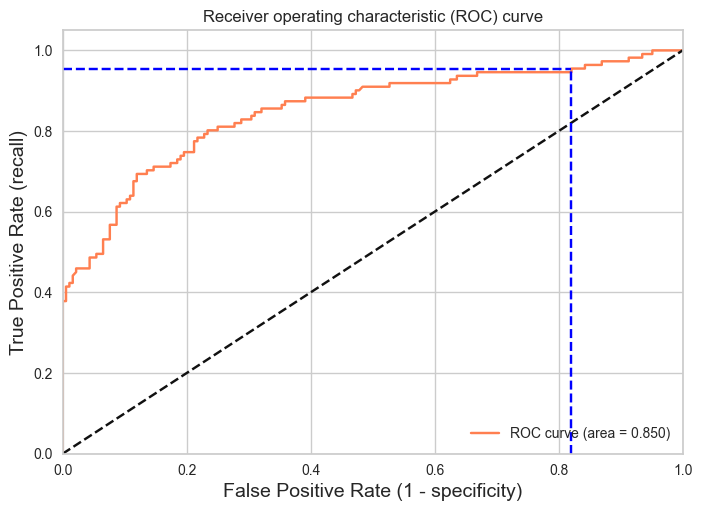

Using a threshold of 0.109 guarantees a sensitivity of 0.955 and a specificity of 0.179, i.e. a false positive rate of 82.07%.


In [101]:
#Model Evaluation based on simple train/test split
y_pred = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
print('Train/Test split results:')
print(log_reg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(log_reg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
print(log_reg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

idx = np.min(np.where(tpr > 0.95))

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

<h3> SHAP </h3>

In [51]:
perm = PermutationImportance(log_reg, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.1939 ± 0.0626,sex
0.1010 ± 0.0282,pclass
0.0285 ± 0.0175,age
0.0122 ± 0.0266,companions
0.0034 ± 0.0074,embarked_C
0.0020 ± 0.0101,embarked_S
0.0014 ± 0.0092,embarked_Q
-0.0034 ± 0.0096,fare


In [67]:
explainer = shap.KernelExplainer(log_reg.predict_proba, link='logit', data=X_train)
shap_values = explainer.shap_values(X_test)

X does not have valid feature names, but LogisticRegression was fitted with feature names
Using 596 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/295 [00:00<?, ?it/s]X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
  0%|          | 1/295 [00:00<02:16,  2.16it/s]X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
  1%|          | 2/295 [00:00<02:12,  2.21it/s]X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
  1%|          | 3/295 [00:01<02:11,  2.22it/s]X does not have valid fe

In [68]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X.iloc[0,:], link='logit')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


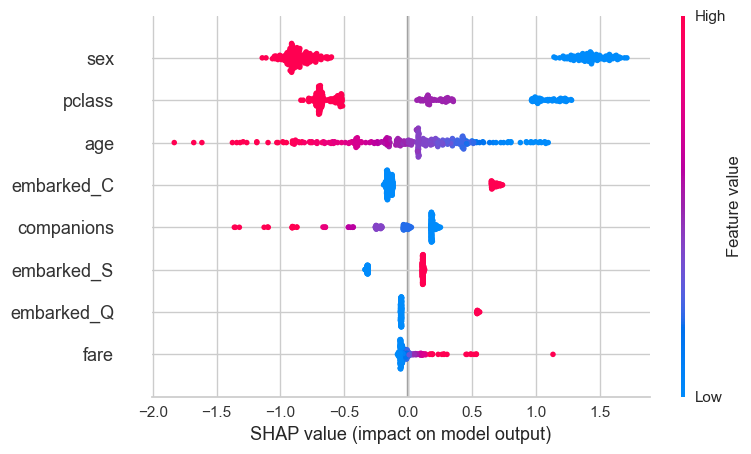

In [70]:
shap.summary_plot(shap_values[1], X_test)

References <br>
Johari, N. (2013). Stress and Coping Strategies among Commuter and Non-commuter Students. ResearchGate. https://doi.org/10.13140//RG.2.2.19157.83688
